Version Notes:

Base assets don't improve predictability??? (ie. can't match R-squareds and test-stats/pvalues)

Bootstrap correct??? (does author even do time-series bootstrap?)

# Creation of GDP and CPI Mimicking portfolios
Note: could use unexpected inflation from Chen, Roll and Ross, projected onto asset returns as a robustness test

## Data Prep

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [48]:
def get_data(date):
    '''
    Imports and cleans data at the monthly or quarterly frequency.
    '''
    if date == 'monthly': data = pd.read_csv('merged_data.csv', index_col=0)
    else: data = pd.read_csv('merged_data_q.csv', index_col=0)
    
    data['def'] = np.log(data['corp_bond_return']/data['corp_bond_return'].shift(1)) - data['20y_return']
    data['term'] = data['30y_return'] - data['rf']
    
    data['defy'] = (data['BAA'] - data['AAA'])/100
    data['termy'] = (data['10 year'] - data['1 year'])/100
    
    # Predictors
    predictors = data[['SL', 'SM', 'SH', 'BL', 'HM', 'BH',
                                   'def', 'term', 'defy', 'termy', 'rf']].copy().dropna()
    portfolios = ['SL', 'SM', 'SH', 'BL', 'HM', 'BH']
    
    for portfolio in portfolios:
        predictors[portfolio] = predictors[portfolio]/100 - predictors['rf'] 
    
    if date == 'monthly':
        # GDP & CPI
        gdp = data['BBKMGDP'].rename('gdp').to_frame().iloc[:-3]
        cpi = data['CPIAUCSL'].rename('cpi').to_frame().iloc[:-3]

        # Transformations 
        gdp['gdp_mom'] = gdp['gdp'] / 100
        gdp['level'] = (1 + gdp['gdp_mom']).cumprod()
        gdp['gdp_yoy'] = np.log(gdp['level'] / gdp['level'].shift(12)) # 4 quarter change = 12 month change

        cpi['cpi_mom'] = np.log(cpi['cpi'] / cpi['cpi'].shift(1))
        cpi['cpi_yoy'] = np.log(cpi['cpi'] / cpi['cpi'].shift(12))
        cpi = cpi.shift(1)

        # Data up to pre-COVID
        predictors = predictors.loc[:'2020']
        gdp = gdp.loc[:'2020']
        cpi = cpi.loc[:'2020']
    
    else:
        # GDP & CPI
        gdp = data['GDPC1'].rename('gdp').to_frame().iloc[:-3]
        cpi = data['CPIAUCSL'].rename('cpi').to_frame().iloc[:-3]

        # Transformations 
        gdp['gdp_qoq'] = np.log(gdp['gdp'] / gdp['gdp'].shift(1))
        gdp['gdp_4qoq'] = np.log(gdp['gdp'] / gdp['gdp'].shift(4))

        cpi['cpi_qoq'] = np.log(cpi['cpi'] / cpi['cpi'].shift(1))
        cpi['cpi_4qoq'] = np.log(cpi['cpi'] / cpi['cpi'].shift(4))
        cpi = cpi.shift(1)

    # Data up to pre-COVID
    # predictors = predictors.loc[:'2020']
    # gdp = gdp.loc[:'2020']
    # cpi = cpi.loc[:'2020']
    
    return predictors, gdp, cpi

In [49]:
predictors_q, gdp_q, cpi_q = get_data('quarterly')

In [50]:
predictors, gdp, cpi = get_data('monthly')

## Can the base assets predict future GDP & CPI?
Since this is an expectation of monthly GDP, instead of "news related to future GDP growth", this factor would be more related to innovations in expectations of future GDP growth. 

In [61]:
def pred(y, X, test):
    '''
    Function to run prediction and return the Wald Statistics based on coefficient restrictions ('test').
    '''
    
    model = sm.OLS(y,X).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    wald = model.wald_test(','.join(test), scalar=True, use_f=False)
    
    return [wald.statistic, wald.pvalue]

In [113]:
def monthly_prediction():
    '''
    Function to run several prediction models at the monthly frequency
    '''
    
    # Predictor Data
    controls = sm.add_constant(predictors.iloc[:,-3:].shift(2).dropna())
    constant = controls.iloc[:,0]
    assets = predictors.iloc[1:,0:8].shift(1).dropna()
    
    # Outcome Variables
    gdp_mom = gdp['gdp_mom'].loc['1973-04':].iloc[2:]
    gdp_yoy = gdp['gdp_yoy'].loc['1973-04':].iloc[2:]
    
    cpi_mom = cpi['cpi_mom'].loc['1973-04':].iloc[2:]
    cpi_yoy = cpi['cpi_yoy'].loc['1973-04':].iloc[2:]
    
    
    wald_stats = {}
    wald_stats['Legend'] = ['Wald Statistic', 'p-value']
    # Control Models
    coeffs_0 = [x + '=0' for x in controls.iloc[:,1:]]

    wald_stats['gdp_mom_control'] = pred(gdp_mom,controls,coeffs_0)   
    wald_stats['cpi_mom_control'] = pred(cpi_mom,controls,coeffs_0)

    wald_stats['gdp_yoy_control'] = pred(gdp_yoy,controls,coeffs_0)   
    wald_stats['cpi_yoy_control'] = pred(cpi_yoy,controls,coeffs_0)
    
    # Only Base Assets
    coeffs_1 = [x + '=0' for x in assets]

    wald_stats['gdp_mom_assets'] = pred(gdp_mom,assets,coeffs_1)
    wald_stats['cpi_mom_assets'] = pred(cpi_mom,assets,coeffs_1)

    wald_stats['gdp_yoy_assets'] = pred(gdp_yoy,assets,coeffs_1)
    wald_stats['gdp_yoy_assets'] = pred(gdp_yoy,assets,coeffs_1)

    # Base Assets + Controls    
    wald_stats['gdp_mom_assets_controls'] = pred(gdp_mom,pd.concat([controls, assets], axis=1),coeffs_1)
    wald_stats['cpi_mom_assets_controls'] = pred(cpi_mom,pd.concat([controls, assets], axis=1),coeffs_1)
                                                 
    wald_stats['gdp_yoy_assets_controls'] = pred(gdp_yoy,pd.concat([controls, assets], axis=1),coeffs_1)
    wald_stats['cpi_yoy_assets_controls'] = pred(cpi_yoy,pd.concat([controls, assets], axis=1),coeffs_1)
    
    return wald_stats

In [116]:
pd.DataFrame(monthly_prediction()).set_index('Legend').T

Legend,Wald Statistic,p-value
gdp_mom_control,14.336506,2.481118e-03
cpi_mom_control,48.055482,2.072368e-10
gdp_yoy_control,51.380630,4.058787e-11
cpi_yoy_control,67.292079,1.621618e-14
gdp_mom_assets,37.392282,9.745848e-06
cpi_mom_assets,20.046992,1.015972e-02
gdp_yoy_assets,27.567900,5.637835e-04
gdp_mom_assets_controls,10.051108,2.614571e-01
cpi_mom_assets_controls,48.758426,7.072884e-08
gdp_yoy_assets_controls,10.683367,2.202934e-01


In [37]:
# Data
controls = sm.add_constant(predictors.iloc[:,-3:].shift(2).dropna())
constant = controls.iloc[:,0]
assets = predictors.iloc[1:,0:8].shift(1).dropna()
y = gdp['gdp_yoy'].loc['1973-04':].iloc[2:]

### GDP Control Model

In [38]:
control_model = sm.OLS(y,controls).fit(cov_type='HAC', cov_kwds={'maxlags':12})
coeffs_0 = [x + '=0' for x in controls.iloc[:,1:]]
print(control_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False))
# control_model.summary()

<Wald test (chi2): statistic=37.73969606900389, p-value=3.208854422231309e-08, df_denom=3>


### GDP Bootstrap
Vassalou (2003) use a bootstrap procedure to see if the base assets are jointly significant in predicted GDP above and beyond the control variables.

Specifically the bootstrap procedure is as follows:

1) The regression is estimated: 

<font size=3>
$
\%\Delta GDP_{t,t+12} = a + cB_{t-1,t} + kZ_{t-2,t-1} + e_{t,t+12}
$
</font>

Where B is a vector of returns on the 8 base assets, and Z is a vector of control variables. The Wald Statistic and p-value is stored.

2) Draw a random sample (with replacement) of the explanatory variables and estimated residuals

3) Compute a GDP growth rate forcast assuming c=0

<font size=3>
$
\%\Delta \hat{GDP}_{t,t+12} = \hat{a} + \hat{k}Z_{t-2,t-1} + \hat{e}_{t,t+12}
$
</font>

4) Regress the null GDP growth rate from (3) on the bootstrapped sample of explanatory variables; compute the Wald Statistic

6) This is repeated 10,000 times. The actual Wald Statistic is compared against the bootstrapped distribution, and the emprical p-value is computed. 

#### Only base assets

In [11]:
# Initial Model
model1 = sm.OLS(y, pd.concat([constant, assets], axis=1)).fit(cov_type='HAC', cov_kwds={'maxlags':12})

coeffs1_0 = [x + '=0' for x in assets]
wald_stat1 = model1.wald_test(','.join(coeffs1_0), scalar=True, use_f=False).statistic
p1 = model1.wald_test(','.join(coeffs1_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p1:0.5f}', 'Wald Stat= ', f'{wald_stat1:0.3f}')

P-value= 0.51426 Wald Stat=  7.209


In [12]:
# model1.summary()

In [13]:
sample_df1 = pd.concat([y, constant, assets], axis=1)
n = len(sample_df1)

In [14]:
# Bootstrap
boot1_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = sample_df1.sample(n=n, replace=True)
    
    boot_model = sm.OLS(boot_df['gdp_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    boot1_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

boot1_wald = np.array(boot1_wald)

In [15]:
empirical_p1 = np.sum(boot1_wald <= wald_stat1)/len(boot1_wald)
print(f'{empirical_p1: 0.5f}')

 0.07540


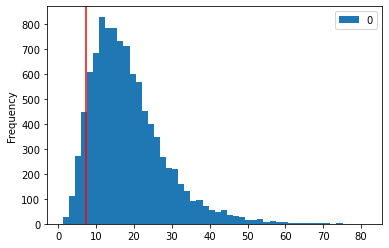

In [38]:
pd.DataFrame(boot1_wald).plot.hist(bins=50).axvline(wald_stat1, color='red')

#### Base assets + Controls

In [39]:
# Initial Model
model2 = sm.OLS(y, pd.concat([controls, assets], axis=1)).fit(cov_type='HAC', cov_kwds={'maxlags':12})

coeffs2_0 = [x + '=0' for x in assets]
wald_stat2 = model2.wald_test(','.join(coeffs2_0), scalar=True, use_f=False).statistic
p2 = model2.wald_test(','.join(coeffs2_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p2:0.5f}', 'Wald Stat= ', f'{wald_stat2:0.3f}')

P-value= 0.22029 Wald Stat=  10.683


In [18]:
# model2.summary()

In [19]:
sample_df2 = pd.concat([y, controls, assets], axis=1)
n = len(sample_df2)

In [20]:
# Bootstrap
boot2_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = sample_df2.sample(n=n, replace=True)
    
    boot_model = sm.OLS(boot_df['gdp_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    boot2_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

boot2_wald = np.array(boot2_wald)

In [21]:
empirical_p2 = np.sum(boot2_wald <= wald_stat2)/len(boot2_wald)
print(f'{empirical_p2: 0.5f}')

 0.10150


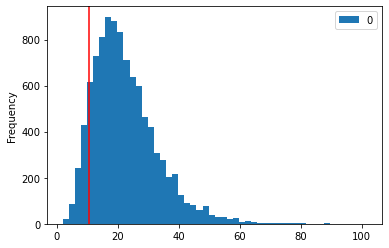

In [40]:
pd.DataFrame(boot2_wald).plot.hist(bins=50).axvline(wald_stat2, color='red')

### CPI

In [22]:
y_cpi = cpi['cpi_yoy'].loc['1973-04':].iloc[2:]

In [23]:
# Initial Model
cpi_model = sm.OLS(y_cpi, pd.concat([controls, assets], axis=1)).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Wald Test for controls vs mean
cpi_coeffs_0 = [x + '=0' for x in pd.concat([controls.iloc[:,1:], assets], axis=1)]
wald_stat_cpi = cpi_model.wald_test(','.join(cpi_coeffs_0), scalar=True, use_f=False).statistic
p_cpi = cpi_model.wald_test(','.join(cpi_coeffs_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p_cpi:0.5f}', 'Wald Stat= ', f'{wald_stat_cpi:0.3f}')

# Wald Test for base assets vs mean + controls
cpi_coeffs_0 = [x + '=0' for x in assets]
wald_stat_cpi = cpi_model.wald_test(','.join(cpi_coeffs_0), scalar=True, use_f=False).statistic
p_cpi = cpi_model.wald_test(','.join(cpi_coeffs_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p_cpi:0.5f}', 'Wald Stat= ', f'{wald_stat_cpi:0.3f}')

P-value= 0.00000 Wald Stat=  112.373
P-value= 0.00141 Wald Stat=  25.251


Base assets do appear to have predictive power (asymptotically)

#### CPI Bootstrap

In [24]:
sample_df_cpi = pd.concat([y_cpi, controls, assets], axis=1)
n = len(sample_df_cpi)

In [25]:
boot_cpi_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = sample_df_cpi.sample(n=n, replace=True)
    
    boot_model = sm.OLS(boot_df['cpi_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    boot_cpi_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

boot_cpi_wald = np.array(boot_cpi_wald)

In [26]:
empirical_p_cpi = np.sum(boot_cpi_wald <= wald_stat_cpi)/len(boot_cpi_wald)
print(f'{empirical_p_cpi: 0.5f}')

 0.08030


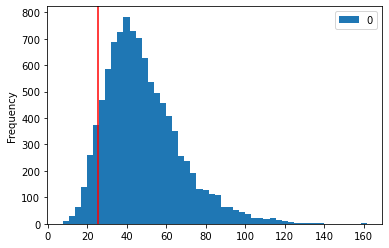

In [41]:
pd.DataFrame(boot_cpi_wald).plot.hist(bins=50).axvline(wald_stat_cpi, color='red')

#### Non-Moving Block Bootstrap
1) Partition the sample into b blocks of length l (retains time series order)
2) Randomly sample (with replacement) blocks of the data
3) Perform the operation of the bootstrap

In [122]:
import random

In [123]:
index = np.linspace(0,len(assets),10,0).round().astype('int')

boot_sample = []
for i in range(len(index)-1):
    boot_sample.append(sample_df_cpi.iloc[index[i]:index[i+1]])

In [125]:
# CPI Block Bootstrap
block_boot_cpi_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = pd.concat([random.choice(boot_sample) for i in range(10)]).sort_index()
    
    boot_model = sm.OLS(boot_df['cpi_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    block_boot_cpi_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

block_boot_cpi_wald = np.array(block_boot_cpi_wald)

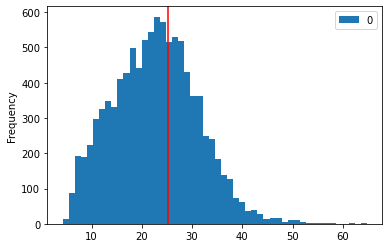

In [126]:
pd.DataFrame(block_boot_cpi_wald).plot.hist(bins=50).axvline(wald_stat_cpi, color='red')

In [127]:
empirical_p_cpi_block = np.mean(block_boot_cpi_wald <= wald_stat_cpi)
print(f'{empirical_p_cpi_block: 0.5f}')

 0.61960


#### Moving Block Bootstrap
1) Decide on block of length l, and then create b blocks of length l, where the data overlaps
2) Randomly sample (with replacement) blocks of the data
3) Perform the operation of the bootstrap

In [153]:
index = range(len(assets))

boot_sample = []
for i in range(len(index)-100):
    boot_sample.append(sample_df_cpi.iloc[index[i]:index[i+100]])

In [154]:
# CPI Moving Block Bootstrap
block_boot_cpi_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = pd.concat([random.choice(boot_sample) for i in range(6)]).sort_index()
    
    boot_model = sm.OLS(boot_df['cpi_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':12})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    block_boot_cpi_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

block_boot_cpi_wald = np.array(block_boot_cpi_wald)

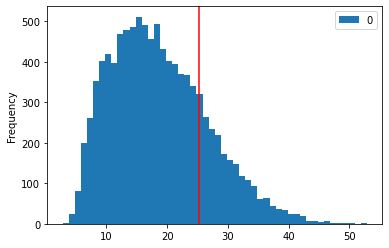

In [155]:
pd.DataFrame(block_boot_cpi_wald).plot.hist(bins=50).axvline(wald_stat_cpi, color='red')

In [156]:
empirical_p_cpi_block = np.mean(block_boot_cpi_wald <= wald_stat_cpi)
print(f'{empirical_p_cpi_block: 0.5f}')

 0.79510


## Factor Creation
Since we are dealing with 2 factors, it is important that the factors are orthogonal. To accomplish this, we can perform a 2-step estimation. 

First, each of the factors can be estimated individually. Since they the regressors are identical in both cases, we can use Multivariate OLS/Seemingly Unrelated Regression, to account for any cross-equation correlation between the error terms.

Second, we can regress factor i on factor j, and then use the residuals as the orthoginalized verison of factor i (ie. the portion of factor i which is orthogonal to factor j).

### Systems Estimation

In [158]:
from linearmodels.system.model import SUR

In [159]:
# GDP and CPI Stacked
y_stacked = pd.merge(y, y_cpi, left_index=True, right_index=True)
X = sm.add_constant(pd.concat([controls, assets], axis=1))

In [160]:
# Step 1
model = SUR.multivariate_ls(y_stacked, X).fit(cov_type='kernel', kernel='bartlett',bandwidth=3)

In [161]:
print(model)

                           System OLS Estimation Summary                           
Estimator:                        OLS   Overall R-squared:                   0.3208
No. Equations.:                     2   McElroy's R-squared:                 0.5026
No. Observations:                 559   Judge's (OLS) R-squared:             0.3208
Date:                Wed, Mar 15 2023   Berndt's R-squared:                  0.7314
Time:                        17:04:09   Dhrymes's R-squared:                 0.3208
                                        Cov. Estimator:                      kernel
                                        Num. Constraints:                      None
                Equation: gdp_yoy, Dependent Variable: gdp_yoy                
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.4614     0.0557     8.2804     0.0000      0.3522      0.5706
defy        

In [162]:
gdp_coeffs = model.params.iloc[4:12]
cpi_coeffs = model.params.iloc[16:]

gdp_factor = gdp_coeffs @ assets.values.T
cpi_factor = cpi_coeffs @ assets.values.T

factors = pd.DataFrame({'gdp_factor':gdp_factor, 'cpi_factor':cpi_factor}, index=assets.index)

<AxesSubplot:>

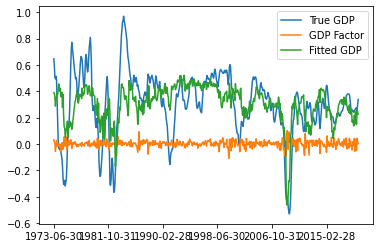

In [183]:
# Plots of factors vs actual values
pd.DataFrame({'True GDP':y, 'GDP Factor':gdp_factor, 'Fitted GDP':model.predict()['gdp_yoy'].iloc[:,0]}).plot()

<AxesSubplot:>

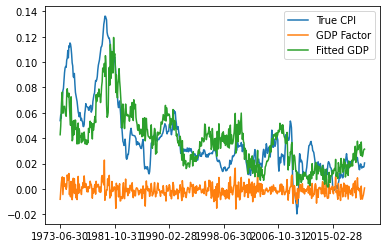

In [184]:
pd.DataFrame({'True CPI':y_cpi, 'GDP Factor':cpi_factor, 'Fitted GDP':model.predict()['cpi_yoy'].iloc[:,0]}).plot()

In [185]:
# Step 2
factor_model = sm.OLS(factors['cpi_factor'], factors['gdp_factor']).fit()
factors['cpi_factor'] = factor_model.resid

In [186]:
# Factor summary stats
factors.describe()

,gdp_factor,cpi_factor
count,559.000000,559.000000
mean,0.001791,-0.000644
std,0.025520,0.004159
min,-0.108707,-0.014245
25%,-0.011512,-0.003137
50%,0.002642,-0.000734
75%,0.015667,0.001868
max,0.101307,0.020444


In [187]:
# Annualized average returns
((1+factors.describe().loc['mean'])**12)-1

gdp_factor    0.021707
cpi_factor   -0.007695
Name: mean, dtype: float64

In [191]:
# factors.to_csv('factors.csv')